# CRI iAtlas notebooks

## Working with clinical outcomes.

    Notebook: clinical_outcomes.ipynb 
    Date: August 16, 2021 
    Author: David L Gibbs 
    Plot type: Survival plots, Kaplan-Meier curves, KM plots

---

notebook repo: https://github.com/CRI-iAtlas/iatlas-notebooks

landing page: https://www.cri-iatlas.org/

portal: https://isb-cgc.shinyapps.io/shiny-iatlas/

email: support@cri-iatlas.org

---

Welcome to the CRI iAtlas notebooks. With these notebooks you'll be able to recreate many of our figures and modules found in the web portal, but with your own data. That means you can plot your samples next to the samples found in our databases.

This is a jupyter notebook running R. The fastest way to get started is to open the notebook using Jupyter lab in MyBinder, it's free and works great.

If you want to run this on your local environment, you'll need Jupyter and an R kernel to use it.<br>
See [this conda guide](https://docs.anaconda.com/anaconda/navigator/tutorials/r-lang/) or [this datacamp guide](https://www.datacamp.com/community/blog/jupyter-notebook-r) to get started.<br>

First we are going to install the iAtlas-modules package to gain access to plotting functions.

In [182]:
try({
    packages = c("magrittr", "wrapr", "dplyr", "feather", "tidyr", "survival", "survminer")

    sapply(packages, function(x) {
      if (!require(x,character.only = TRUE))
        install.packages(x)
        library(x,character.only = TRUE)
    })

    if (!require(iatlas.modules)) {
        devtools::install_github("th86/concordanceIndex")
        library(concordanceIndex)
    }
    
    # and our iatlas package from github
    if (!require(iatlas.modules)) {
      devtools::install_github("CRI-iAtlas/iatlas.modules")
      library(iatlas.modules)
    }},
    silent = TRUE
)


Next we need to read our collection of helper functions found in the 'notebook_functions.R' file.

The main plotting function we're using here is called 'notebook_kmplot', which is a wrapper around ggsurvplot in the survminer package.

Here we'll use source to bring them in.

In [146]:
# git clone the notebook repo to get this file #
# or see: https://github.com/CRI-iAtlas/iatlas-notebooks/blob/main/functions/notebook_functions.R
source('functions/notebook_functions.R')

# Survival plots

These plots are used frequently in cancer research, let's learn what they express and 
how to make them, even using your own data.

Our first simulation is going to have two survival curves, based on group membership.
Each simulated-sample will have a time, a censor status, and a variable that gives group membership.
The censor status lets us know if the event happened, or if the study timed out.
It's also possible for a sample to be censored due to simply dropping out of the 
study, but we won't have that here.

In [147]:

# We are going to simulate how long it takes before an event happens, 
# given there's a probability of it happening each time click
# at some point, it doesn't happen. That's when the trial ends.

sim_event <- function(p, time_pts) {
  # ps is a random uniform integer over a number of time points
  ps = runif(n=time_pts)
  # did it happen at some point?
  qs <- which(ps <= p)
  if(length( which(ps <= p) ) == 0) {
    # made it to the end.
    return(time_pts)
  } else {
    # or the first time it happened.
    return(min(qs))
  }
}


# our simulation parameters
days <- 500
p1 <- 0.01  # event probability for group 1
p2 <- 0.02  # event probability for group 2
p3 <- 0.04  # event probability for group 3

# first simulate whether the event happened
events1 <- sapply(1:100, function(a) sim_event(p=p1, days))
events2 <- sapply(1:100, function(a) sim_event(p=p2, days))
events3 <- sapply(1:100, function(a) sim_event(p=p3, days))

# then the status, depending on the given time
# 1 if the event happened, and 0 if it's censored
status1 <- sapply(events1, function(a) if (a >= days) {0} else {1})
status2 <- sapply(events2, function(a) if (a >= days) {0} else {1})
status3 <- sapply(events3, function(a) if (a >= days) {0} else {1})

sim_df <- data.frame(Variable=c(rep.int('group_a', 100), rep.int('group_b', 100), rep.int('group_c', 100)), 
                 Time=c(events1, events2, events3),
                 Status=c(status1, status2, status3))

# take a look at our dataframe
head(sim_df)

,Variable,Time,Status
,<chr>,<dbl>,<dbl>
1,group_a,150,1
2,group_a,328,1
3,group_a,49,1
4,group_a,366,1
5,group_a,11,1
6,group_a,9,1


To get our plot, we'll the iAtlas notebook_kmplot function to plot the survival curves.

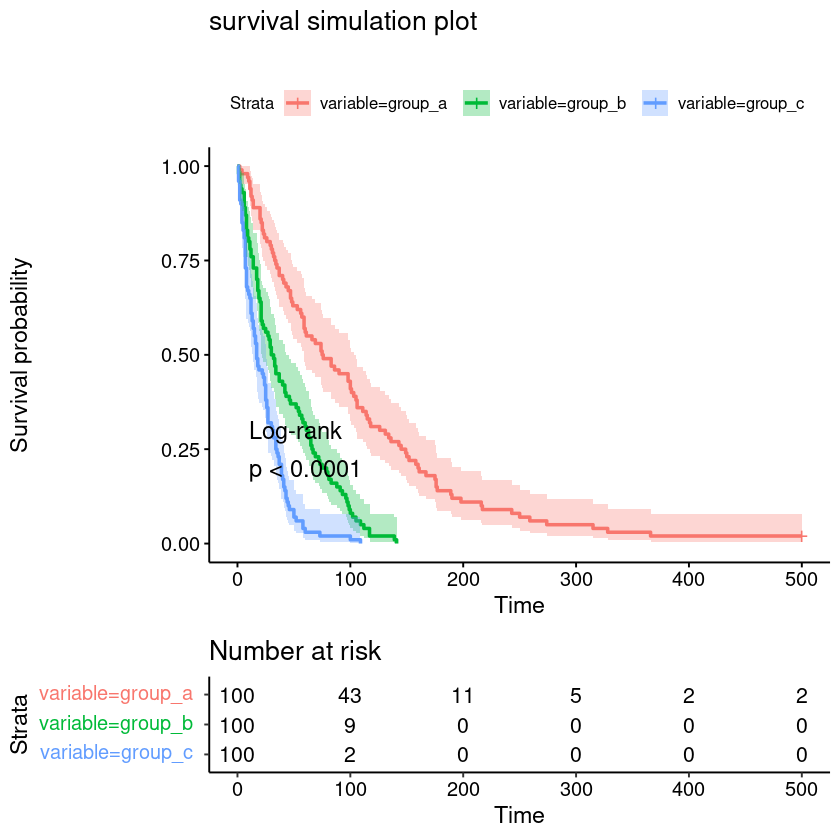

In [148]:

# and make a plot
notebook_kmplot(
   df = sim_df,
   div_method='Group',
   confint = TRUE,
   risktable = TRUE,
   title = 'survival simulation plot',
   subtitle = '',
   group_colors = TRUE,
   facet=TRUE)


 
 ### The notebook_kmplot takes the following arguments

    df: the data frame with Group, Time, and Status columns
    div_method: how the Status should be divided, choices are 'group', 'median', or 'cut'
    k: if the div_method is 'cut', then cut into k parts.
    group_choice = NULL, ## probably delete ## for TCGA groups
    group_subset = NULL


Let's make another plot where we cut a continuous feature into groups.

In [162]:

# our simulation parameters, using the sim_event function above #
days <- 500
p1 <- 0.01  # event probability for group 1
p2 <- 0.10  # event probability for group 2

# first simulate whether the event happened
events1 <- sapply(1:100, function(a) sim_event(p=p1, days))
events2 <- sapply(1:100, function(a) sim_event(p=p2, days))

# then the status, depending on the given time
# 1 if the event happened, and 0 if it's censored
status1 <- sapply(events1, function(a) if (a >= days) {0} else {1})
status2 <- sapply(events2, function(a) if (a >= days) {0} else {1})

# then the variable, depending on the given time
# X if the event happened, and 0 if it's censored
var1 <- sapply(events1, function(a) if (a >= days) {0} else {runif(n = 1, max=1.0, min=0.5)})
var2 <- sapply(events2, function(a) if (a >= days) {0} else {runif(n = 1, max=0.8, min=0.2)})

sim_df_2 <- data.frame(Variable=c(var1, var2), 
                 Time=c(events1, events2),
                 Status=c(status1, status2))

# take a look at our dataframe
head(sim_df_2)

,Variable,Time,Status
,<dbl>,<dbl>,<dbl>
1,0.7222499,78,1
2,0.8131586,41,1
3,0.9658546,116,1
4,0.7520458,80,1
5,0.7998245,74,1
6,0.6754635,68,1


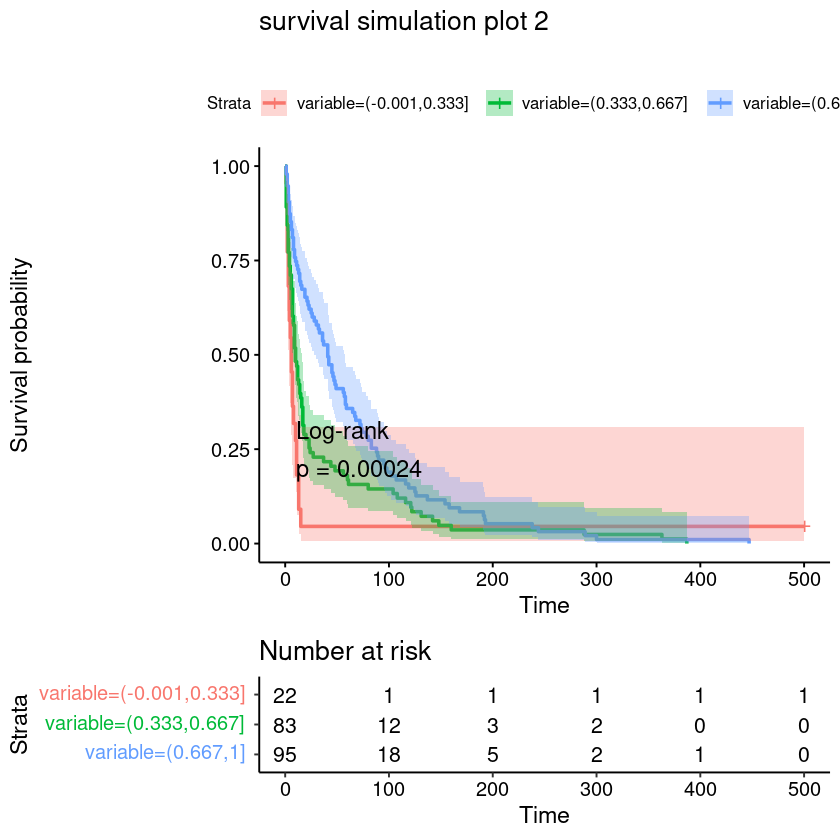

In [163]:

# and make a plot
notebook_kmplot(
   df = sim_df_2,
   div_method='cut',  # 'median splits into 2 groups'
   k=3,
   confint = TRUE,
   risktable = TRUE,
   title = 'survival simulation plot 2',
   subtitle = '',
   group_colors = TRUE,
   facet=TRUE)


# Plot your data next to iAtlas results

Since we ultimately need samples in groups, for mixing your data with iAtlas data, it is probably easiest to manually define the groups.  Let's get some survival data with our get_iatlas_survival_features() function.  This function gives either the overall survival (OS) or progression free interval (PFI) with a given feature of choice.

First we'll look at a demo of the feature extraction function "get_iatlas_survival_feature", and then we'll work to combine two tables, a simulated table with iAtlas tables.

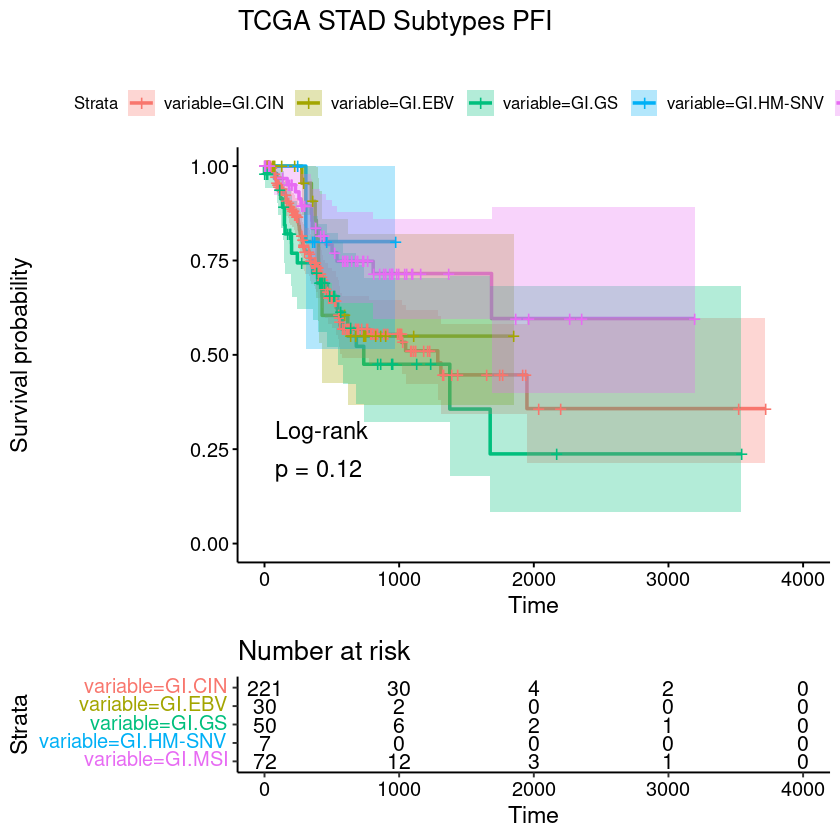

In [151]:
# to extract data from the feature matrix
iatlas_df <- get_iatlas_survial_feature(  
                      group = 'Study',              ## "Study" or any factor in the matrix
                      group_filter='STAD',          ## given the group, the TCGA study name / Tissue type ... can be a vector
                      feature_name = 'Subtype_Curated_Malta_Noushmehr_et_al',  ## feature of interest, molecular subtypes .. **a factor**
                      survival_feature = 'PFI',     ## OS or PFI
                      na_rm=TRUE)

# and make a plot
notebook_kmplot(
   df = iatlas_df,
   div_method='group',  # since we already have groups, we don't need to cut or apply median.
   confint = TRUE,
   risktable = TRUE,
   title = 'TCGA STAD Subtypes PFI',
   subtitle = '',
   group_colors = TRUE,
   facet=TRUE)


Now let's take that extracted table, showing PFI differences between the STAD molecular subtypes, and add another group... potentially our own group. Since we already have groups as part of our first simulation (sim_df), let's use that.

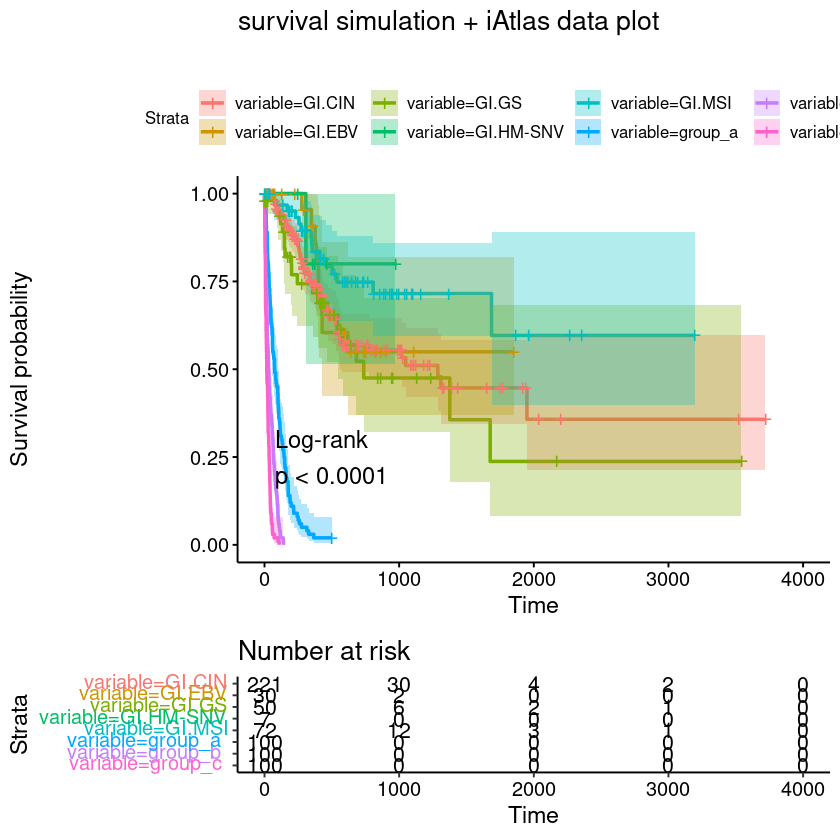

In [152]:
# row bind the tables
combined_df <- rbind(iatlas_df, sim_df)

# and make a plot
notebook_kmplot(
   df = combined_df,
   div_method='group',  # since we already have groups, we don't need to cut or apply median.
   confint = TRUE,
   risktable = TRUE,
   title = 'survival simulation + iAtlas data plot',
   subtitle = '',
   group_colors = TRUE,
   facet=TRUE)



Now, suppose we have tables that don't yet have groups assigned to them, just as if we had gene set scores. In that case we need to generate levels or groups. We can do it as before, this time using 'cut_interval' from the ggplot2 library.  First, we'll extract an iAtlas table, and cut it into factors. Then we'll do the same with our simulation table, row bind the tables, and make a plot.

In [153]:
# going to pull out 
# can use list_iatlas_features() to get a list of features

iatlas_df <- get_iatlas_survial_feature(  
                      group = 'Study',              ## "Study" or any factor in the matrix
                      group_filter='STAD',          ## given the group, the TCGA study name / Tissue type ... can be a vector
                      feature_name = 'B.cells.memory',  ## feature of interest, molecular subtypes .. **a factor**
                      survival_feature = 'PFI',     ## OS or PFI
                      na_rm=TRUE)

iatlas_df[1:5,]

Variable,Time,Status
<dbl>,<int>,<int>
0.00000000,0,0
0.00000000,0,0
0.01470229,1055,0
0.00000000,0,0
0.00000000,385,1


We also have sim_df_2 with simulated values.

In [154]:
sim_df_2[1:5,]

,Variable,Time,Status
,<dbl>,<dbl>,<dbl>
1,0.9115745,31,1
2,0.7514987,25,1
3,0.7359586,224,1
4,0.6055032,30,1
5,0.8276648,101,1


In [155]:
# Here, we'll cut the numeric feature into labeled groups.
var_labels <- cut_interval(x = iatlas_df$Variable, n = 2)  ## see also ?cut_number and ?cut_width
iatlas_df$Variable <- sapply(var_labels, function(a) paste0('iAtlas_',a)) # and prepend a label
iatlas_df[1:5,]

Variable,Time,Status
<chr>,<int>,<int>
"iAtlas_[0,0.242]",0,0
"iAtlas_[0,0.242]",0,0
"iAtlas_[0,0.242]",1055,0
"iAtlas_[0,0.242]",0,0
"iAtlas_[0,0.242]",385,1


In [156]:
# And similarly with our simulated data, we'll cut the numeric feature into labeled groups.
var_labels <- cut_interval(x = sim_df_2$Variable, n = 2)  ## see also ?cut_number and ?cut_width, labels=F makes labels integers
sim_df_2$Variable <- sapply(var_labels, function(a) paste0('sim_',a))  # and prepend a label
sim_df_2[1:5,]

,Variable,Time,Status
,<chr>,<dbl>,<dbl>
1,"sim_(0.497,0.994]",31,1
2,"sim_(0.497,0.994]",25,1
3,"sim_(0.497,0.994]",224,1
4,"sim_(0.497,0.994]",30,1
5,"sim_(0.497,0.994]",101,1


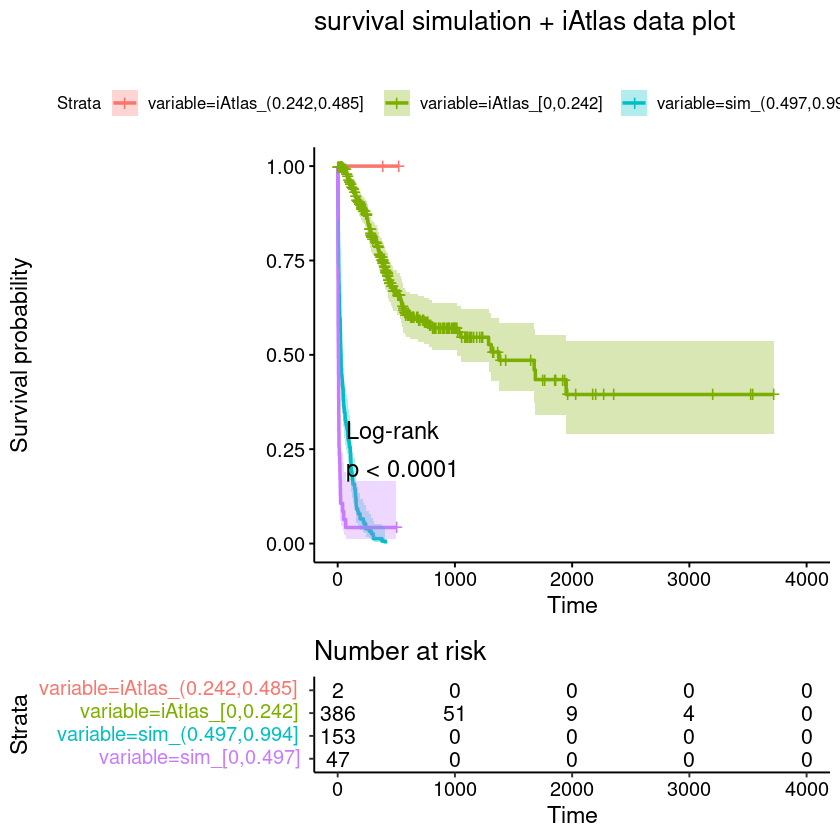

In [157]:
# row bind the tables
combined_df <- rbind(iatlas_df, sim_df_2)

# and make a plot
notebook_kmplot(
   df = combined_df,
   div_method='group',  # since we already have groups, we don't need to cut or apply median.
   confint = TRUE,
   risktable = TRUE,
   title = 'survival simulation + iAtlas data plot',
   subtitle = '',
   group_colors = TRUE,
   facet=TRUE)

That's it, we simulated survival data, extracted real survival data with various features from the iAtlas database, and combined the two into one KM plot.  Exactly the same procedures would be used to plot *your* data next to iAtlas results.  If you'd like help generating the same features as iAtlas, please let us know, we have dockerized workflows available.

# Concordance Heatmaps

In [186]:
source('functions/notebook_functions.R')

df_conc <- get_iatlas_survial_feature_set(
              group = 'Study',  ## Subtype_Immune_Model_Based or Study
              group_filter='STAD',                   ## List of group IDs we want like KICH 
              group_mod = 'iAtlas_',
              feature_name = 'Subtype_Immune_Model_Based',
              feature_set = 'T Helper Cell Score',
              survival_feature = 'OS')

print(df_conc[1:5,])

build_ci_mat(    
  df=df_conc, 
  group_column ='Variable', 
  value_columns =c('Th1.cells', 'Th2.cells', 'Th17.cells'), ## get friendly term function wanted here
  time_column ='Time', 
  status_column ='Status')
    

# A tibble: 5 x 6
  Variable  Time Status Th1.cells Th2.cells Th17.cells
  <chr>    <int>  <int>     <dbl>     <dbl>      <dbl>
1 C3           0      0    -2305.    -1009.      4263.
2 C4           0      0      565.      581.       383.
3 C1        1055      0     -689.      807.      -117.
4 C2           0      0      336.      546.      1923.
5 C1         422      1     -642.     1018.     -2451.


,C1,C2,C3,C4,C6
Th1 Cells,0.5620615,0.5450937,0.6101083,0.6153846,0.63636364
Th2 Cells,0.4668106,0.4200662,0.5956679,0.6923077,0.09090909
Th17 Cells,0.4730167,0.4631753,0.3537906,0.6153846,0.45454545


### We would love to hear from you!

That concludes the notebook demonstrating how iAtlas style barplots can be made mixing new data with what's in the iAtlas database. 

notebook repo: https://github.com/CRI-iAtlas/iatlas-notebooks

landing page:  https://www.cri-iatlas.org/

portal: https://isb-cgc.shinyapps.io/shiny-iatlas/

email:  support@cri-iatlas.org